# Final model

### Resources

- https://geemap.org/notebooks/46_local_rf_training/

## Setup

In [1]:
from google.colab import drive
import os
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import ee
import geemap
from geemap import ml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/land_cover_classification_kaza

/content/drive/MyDrive/land_cover_classification_kaza


In [4]:
user_id = 'ee-alexvmt'
asset_name = 'mufunta_random_forest'

In [5]:
ee.Authenticate()
ee.Initialize(project=user_id)

## Load train and test set

In [6]:
train = pd.read_csv('data/train.csv')
train

B11_Q1  B11_Q2  B11_Q3  B11_Q4  B12_Q1  B12_Q2  B12_Q3  B12_Q4   B2_Q1  \
0     1676.5  1855.5  2356.0  2994.0   843.5  1048.5  1518.0  2345.0   328.0   
1     1682.0  1729.5  2152.0  2983.0   836.0   994.5  1518.0  1958.0   263.0   
2     1927.5  2226.0  2146.0  3504.0   968.0  1262.5  1428.0  2341.0   293.0   
3     1901.0  1937.0  2234.0  2910.0  1017.5  1129.0  1385.0  1951.0   345.0   
4     1879.5  2026.5  2349.0  2888.0   919.5  1134.0  1435.0  2343.0   303.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3300  2955.5  2885.5  3179.0  3912.0  2391.0  2294.0  2725.0  3652.0   626.0   
3301  2932.0  3434.0  3763.0  4097.0  2127.0  2967.5  3378.0  3772.0   953.0   
3302  2685.0  3169.0  3626.0  3953.5  2078.0  2625.5  3170.0  3640.0  1102.0   
3303  1352.0  3222.0  3534.0  3774.0   704.0  3107.5  3353.0  3469.0   281.0   
3304  2781.0  3157.5  3770.0  3891.5  2190.0  2697.0  3226.0  3433.0  1318.0   

       B2_Q2  ...   NDVI_Q3  NDWI_MCF_Q3  NDWI_GAO_Q3   SAVI_Q3    EVI_Q3  \
0      432.0  ...  0.341223    -0.455064     0.146712  0.511750  0.721234   
1      320.0  ...  0.427598    -0.466317     0.049468  0.641260  1.078874   
2      420.0  ...  0.466993    -0.495726     0.190476  0.700367  1.177351   
3      385.0  ...  0.419711    -0.501458     0.195936  0.629457  0.952158   
4      373.5  ...  0.442693    -0.499628     0.167875  0.663921  1.061673   
...      ...  ...       ...          ...          ...       ...       ...   
3300   692.0  ...  0.193269    -0.327283    -0.076012  0.289866  0.395575   
3301  1104.0  ...  0.124567    -0.307847    -0.130144  0.186831  0.247423   
3302  1127.0  ...  0.172291    -0.296024    -0.091222  0.258408  0.343363   
3303  1115.0  ...  0.168149    -0.283480    -0.121592  0.252196  0.426926   
3304  1198.0  ...  0.140119    -0.255276    -0.127184  0.210154  0.323635   

       NDVI_Q4  NDWI_MCF_Q4  NDWI_GAO_Q4   SAVI_Q4    EVI_Q4  
0     0.346628    -0.430530    -0.010558  0.519865  0.832160  
1     0.525872    -0.533253     0.128616  0.788690  1.418831  
2     0.499757    -0.563277     0.136640  0.749544  1.123387  
3     0.530376    -0.591069     0.162481  0.795451  1.236495  
4     0.387115    -0.467694     0.027599  0.580591  0.902442  
...        ...          ...          ...       ...       ...  
3300  0.176161    -0.269631    -0.152778  0.264213  0.494465  
3301  0.137538    -0.347435    -0.114987  0.206287  0.250000  
3302  0.156879    -0.279814    -0.137856  0.235294  0.308250  
3303  0.160305    -0.268532    -0.146208  0.240431  0.388466  
3304  0.119141    -0.201222    -0.146627  0.178693  0.319474  

[3305 rows x 63 columns]

In [7]:
X_train = train.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_train

B11_Q1  B11_Q2  B11_Q3  B11_Q4  B12_Q1  B12_Q2  B12_Q3  B12_Q4   B2_Q1  \
0     1676.5  1855.5  2356.0  2994.0   843.5  1048.5  1518.0  2345.0   328.0   
1     1682.0  1729.5  2152.0  2983.0   836.0   994.5  1518.0  1958.0   263.0   
2     1927.5  2226.0  2146.0  3504.0   968.0  1262.5  1428.0  2341.0   293.0   
3     1901.0  1937.0  2234.0  2910.0  1017.5  1129.0  1385.0  1951.0   345.0   
4     1879.5  2026.5  2349.0  2888.0   919.5  1134.0  1435.0  2343.0   303.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3300  2955.5  2885.5  3179.0  3912.0  2391.0  2294.0  2725.0  3652.0   626.0   
3301  2932.0  3434.0  3763.0  4097.0  2127.0  2967.5  3378.0  3772.0   953.0   
3302  2685.0  3169.0  3626.0  3953.5  2078.0  2625.5  3170.0  3640.0  1102.0   
3303  1352.0  3222.0  3534.0  3774.0   704.0  3107.5  3353.0  3469.0   281.0   
3304  2781.0  3157.5  3770.0  3891.5  2190.0  2697.0  3226.0  3433.0  1318.0   

       B2_Q2  ...   NDVI_Q3  NDWI_MCF_Q3  NDWI_GAO_Q3   SAVI_Q3    EVI_Q3  \
0      432.0  ...  0.341223    -0.455064     0.146712  0.511750  0.721234   
1      320.0  ...  0.427598    -0.466317     0.049468  0.641260  1.078874   
2      420.0  ...  0.466993    -0.495726     0.190476  0.700367  1.177351   
3      385.0  ...  0.419711    -0.501458     0.195936  0.629457  0.952158   
4      373.5  ...  0.442693    -0.499628     0.167875  0.663921  1.061673   
...      ...  ...       ...          ...          ...       ...       ...   
3300   692.0  ...  0.193269    -0.327283    -0.076012  0.289866  0.395575   
3301  1104.0  ...  0.124567    -0.307847    -0.130144  0.186831  0.247423   
3302  1127.0  ...  0.172291    -0.296024    -0.091222  0.258408  0.343363   
3303  1115.0  ...  0.168149    -0.283480    -0.121592  0.252196  0.426926   
3304  1198.0  ...  0.140119    -0.255276    -0.127184  0.210154  0.323635   

       NDVI_Q4  NDWI_MCF_Q4  NDWI_GAO_Q4   SAVI_Q4    EVI_Q4  
0     0.346628    -0.430530    -0.010558  0.519865  0.832160  
1     0.525872    -0.533253     0.128616  0.788690  1.418831  
2     0.499757    -0.563277     0.136640  0.749544  1.123387  
3     0.530376    -0.591069     0.162481  0.795451  1.236495  
4     0.387115    -0.467694     0.027599  0.580591  0.902442  
...        ...          ...          ...       ...       ...  
3300  0.176161    -0.269631    -0.152778  0.264213  0.494465  
3301  0.137538    -0.347435    -0.114987  0.206287  0.250000  
3302  0.156879    -0.279814    -0.137856  0.235294  0.308250  
3303  0.160305    -0.268532    -0.146208  0.240431  0.388466  
3304  0.119141    -0.201222    -0.146627  0.178693  0.319474  

[3305 rows x 60 columns]

In [8]:
y_train = train['LC_Nr']
y_train

0       7
1       7
2       7
3       7
4       7
       ..
3300    3
3301    3
3302    3
3303    3
3304    3
Name: LC_Nr, Length: 3305, dtype: int64

In [9]:
test = pd.read_csv('data/test.csv')
test

B11_Q1  B11_Q2       B11_Q3  B11_Q4  B12_Q1  B12_Q2  B12_Q3  B12_Q4  \
0      1549.0  1593.0  1749.666667  2217.0   716.0   807.0  1045.0  1556.0   
1      1424.5  1320.0  1563.000000  1675.0   607.5   606.0   833.0   878.0   
2      1717.0  1808.5  1957.000000  3563.0   873.5  1022.0  1439.0  2501.0   
3      1606.0  1688.5  2052.000000  2454.0   749.0   873.0  1207.0  1798.0   
4      1681.0  1837.5  1990.000000  2658.5   910.0  1039.5  1228.0  1887.5   
...       ...     ...          ...     ...     ...     ...     ...     ...   
78316  3189.0  2890.5  2844.000000  3182.0  2972.5  2846.5  2848.0  3276.0   
78317  1389.0  3557.5  3832.000000  3994.0   735.0  3635.5  3899.0  3955.0   
78318  1376.0  3709.0  3940.500000  3963.0   707.0  3779.5  3886.5  3880.0   
78319  3904.0  3587.5  4037.000000  4515.0  3472.0  3207.0  4012.0  4244.0   
78320  1431.0  3772.0  3983.500000  4036.0   758.0  3779.0  3965.0  3799.0   

        B2_Q1   B2_Q2  ...   NDVI_Q3  NDWI_MCF_Q3  NDWI_GAO_Q3   SAVI_Q3  \
0       272.0   306.0  ...  0.553990    -0.520683     0.236111  0.830794   
1       223.0   240.0  ...  0.594102    -0.544538     0.376264  0.890960   
2       256.0   313.0  ...  0.392796    -0.475023     0.060398  0.589068   
3       266.5   298.0  ...  0.495253    -0.534091     0.220536  0.742733   
4       305.0   343.0  ...  0.439034    -0.522998     0.185676  0.658419   
...       ...     ...  ...       ...          ...          ...       ...   
78316  1312.0   976.0  ...  0.073494    -0.195171    -0.230238  0.110224   
78317   285.0  1111.0  ...  0.163068    -0.261584    -0.212564  0.244575   
78318   290.0  1274.0  ...  0.149789    -0.257499    -0.175679  0.224660   
78319  1668.0  1237.0  ...  0.220893    -0.313895    -0.231998  0.331300   
78320   284.0  1165.0  ...  0.155655    -0.261305    -0.211612  0.233456   

         EVI_Q3   NDVI_Q4  NDWI_MCF_Q4  NDWI_GAO_Q4   SAVI_Q4    EVI_Q4  
0      1.976179  0.527553    -0.491347     0.120407  0.791177  1.819511  
1      1.890177  0.688332    -0.592319     0.421226  1.032296  2.092857  
2      0.927877  0.434343    -0.537212     0.063471  0.651433  0.914699  
3      1.207795  0.551214    -0.552133     0.186057  0.826698  1.485322  
4      1.026920  0.489942    -0.545347     0.097646  0.734793  1.091671  
...         ...       ...          ...          ...       ...       ...  
78316  0.150580  0.057531    -0.149517    -0.236693  0.086286  0.140127  
78317  0.435583  0.145235    -0.252047    -0.179365  0.217830  0.373902  
78318  0.388956  0.150969    -0.256890    -0.206093  0.226428  0.423087  
78319  0.762940  0.273359    -0.357739    -0.183161  0.409995  4.095052  
78320  0.407052  0.145430    -0.246448    -0.197856  0.218120  0.372721  

[78321 rows x 63 columns]

In [10]:
X_test = test.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_test

B11_Q1  B11_Q2       B11_Q3  B11_Q4  B12_Q1  B12_Q2  B12_Q3  B12_Q4  \
0      1549.0  1593.0  1749.666667  2217.0   716.0   807.0  1045.0  1556.0   
1      1424.5  1320.0  1563.000000  1675.0   607.5   606.0   833.0   878.0   
2      1717.0  1808.5  1957.000000  3563.0   873.5  1022.0  1439.0  2501.0   
3      1606.0  1688.5  2052.000000  2454.0   749.0   873.0  1207.0  1798.0   
4      1681.0  1837.5  1990.000000  2658.5   910.0  1039.5  1228.0  1887.5   
...       ...     ...          ...     ...     ...     ...     ...     ...   
78316  3189.0  2890.5  2844.000000  3182.0  2972.5  2846.5  2848.0  3276.0   
78317  1389.0  3557.5  3832.000000  3994.0   735.0  3635.5  3899.0  3955.0   
78318  1376.0  3709.0  3940.500000  3963.0   707.0  3779.5  3886.5  3880.0   
78319  3904.0  3587.5  4037.000000  4515.0  3472.0  3207.0  4012.0  4244.0   
78320  1431.0  3772.0  3983.500000  4036.0   758.0  3779.0  3965.0  3799.0   

        B2_Q1   B2_Q2  ...   NDVI_Q3  NDWI_MCF_Q3  NDWI_GAO_Q3   SAVI_Q3  \
0       272.0   306.0  ...  0.553990    -0.520683     0.236111  0.830794   
1       223.0   240.0  ...  0.594102    -0.544538     0.376264  0.890960   
2       256.0   313.0  ...  0.392796    -0.475023     0.060398  0.589068   
3       266.5   298.0  ...  0.495253    -0.534091     0.220536  0.742733   
4       305.0   343.0  ...  0.439034    -0.522998     0.185676  0.658419   
...       ...     ...  ...       ...          ...          ...       ...   
78316  1312.0   976.0  ...  0.073494    -0.195171    -0.230238  0.110224   
78317   285.0  1111.0  ...  0.163068    -0.261584    -0.212564  0.244575   
78318   290.0  1274.0  ...  0.149789    -0.257499    -0.175679  0.224660   
78319  1668.0  1237.0  ...  0.220893    -0.313895    -0.231998  0.331300   
78320   284.0  1165.0  ...  0.155655    -0.261305    -0.211612  0.233456   

         EVI_Q3   NDVI_Q4  NDWI_MCF_Q4  NDWI_GAO_Q4   SAVI_Q4    EVI_Q4  
0      1.976179  0.527553    -0.491347     0.120407  0.791177  1.819511  
1      1.890177  0.688332    -0.592319     0.421226  1.032296  2.092857  
2      0.927877  0.434343    -0.537212     0.063471  0.651433  0.914699  
3      1.207795  0.551214    -0.552133     0.186057  0.826698  1.485322  
4      1.026920  0.489942    -0.545347     0.097646  0.734793  1.091671  
...         ...       ...          ...          ...       ...       ...  
78316  0.150580  0.057531    -0.149517    -0.236693  0.086286  0.140127  
78317  0.435583  0.145235    -0.252047    -0.179365  0.217830  0.373902  
78318  0.388956  0.150969    -0.256890    -0.206093  0.226428  0.423087  
78319  0.762940  0.273359    -0.357739    -0.183161  0.409995  4.095052  
78320  0.407052  0.145430    -0.246448    -0.197856  0.218120  0.372721  

[78321 rows x 60 columns]

In [11]:
y_test = test['LC_Nr']
y_test

0        7
1        7
2        7
3        7
4        7
        ..
78316    3
78317    3
78318    3
78319    3
78320    3
Name: LC_Nr, Length: 78321, dtype: int64

## Train random forest with default hyperparameters

In [12]:
# for some reason there are inf values in EVI_Q3
# we replace them with the column's median for the sake of simplicity
evi_q3_median = X_train[['EVI_Q3']].median()
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(evi_q3_median)

In [13]:
rf_default = RandomForestClassifier()

In [14]:
rf_default.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
y_train_pred = rf_default.predict(X_train)
y_test_pred = rf_default.predict(X_test)

## Evaluation

### Train set classification metrics

In [16]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [17]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [18]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [19]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [20]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [21]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

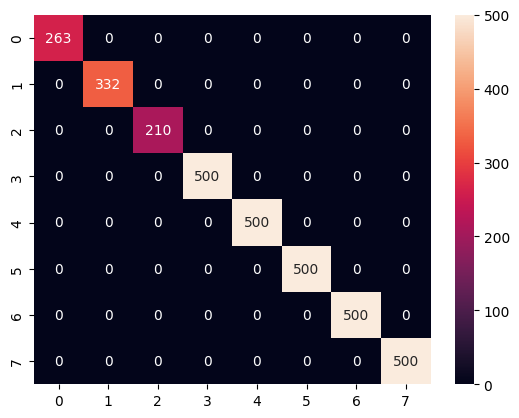

In [22]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [23]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.9303


In [24]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7720


In [25]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.9322


In [26]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.8200


In [27]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95       113
           2       0.25      0.97      0.40       143
           3       0.59      0.88      0.71        90
           4       0.99      0.95      0.97     17628
           5       0.74      0.92      0.82      3248
           6       0.72      0.86      0.79      8266
           7       0.97      0.93      0.95     35183
           8       0.99      0.95      0.97     13650

    accuracy                           0.93     78321
   macro avg       0.77      0.93      0.82     78321
weighted avg       0.94      0.93      0.93     78321



In [28]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  113,     0,     0,     0,     0,     0,     0,     0],
       [    0,   139,     0,     3,     0,     1,     0,     0],
       [    0,     7,    79,     3,     0,     1,     0,     0],
       [    0,   351,    49, 16704,   253,   114,   130,    27],
       [    0,     9,     0,    19,  2985,   138,     5,    92],
       [    0,    40,     0,    36,   243,  7098,   832,    17],
       [    0,     0,     0,     0,    20,  2390, 32768,     5],
       [   11,     0,     6,    30,   519,    68,    37, 12979]])

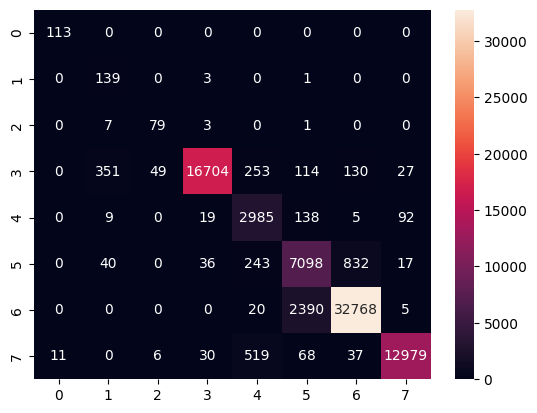

In [29]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Train random forest with optimized hyperparameters

Get optimized hyperparameters from notebook called `optimization.ipynb`.

In [ ]:
rf_optimized = RandomForestClassifier(bootstrap=False, max_features=4, min_samples_split=3,
                           n_estimators=512, n_jobs=1, random_state=1,
                           warm_start=True)

In [ ]:
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=4, min_samples_split=3,
                       n_estimators=512, n_jobs=1, random_state=1,
                       warm_start=True)

In [ ]:
y_train_pred = rf_optimized.predict(X_train)
y_test_pred = rf_optimized.predict(X_test)

## Evaluation

### Train set classification metrics

In [ ]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [ ]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [ ]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [ ]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [ ]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

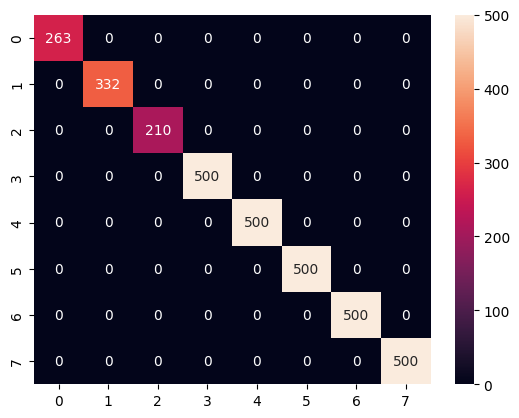

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [ ]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.8979


In [ ]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7383


In [ ]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.9031


In [ ]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.7793


In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.85      1.00      0.92       113
           2       0.15      0.94      0.26       143
           3       0.68      0.87      0.76        90
           4       0.99      0.91      0.95     17628
           5       0.68      0.87      0.76      3248
           6       0.63      0.82      0.71      8266
           7       0.96      0.91      0.93     35183
           8       0.97      0.91      0.94     13650

    accuracy                           0.90     78321
   macro avg       0.74      0.90      0.78     78321
weighted avg       0.92      0.90      0.91     78321



In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  113,     0,     0,     0,     0,     0,     0,     0],
       [    0,   134,     0,     7,     2,     0,     0,     0],
       [    0,     5,    78,     6,     1,     0,     0,     0],
       [    0,   700,    36, 16080,   228,   442,   127,    15],
       [    0,    25,     0,    22,  2830,   174,     9,   188],
       [    0,    34,     0,    80,   365,  6789,   967,    31],
       [    0,     0,     0,     0,    15,  3162, 31867,   139],
       [   20,     0,     1,    41,   719,   274,   164, 12431]])

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Convert sklearn classifier object to a list of strings

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
start_time = time.perf_counter()
trees = ml.rf_to_strings(rf_default, X_train.columns)
end_time = time.perf_counter()
run_time = round((end_time - start_time) / 60, 2)
print('Run time: {} minutes.'.format(run_time))

Run time: 0.98 minutes.


In [ ]:
# print the first tree to see the result
print(trees[0])

1) root 2075 9999 9999 (112.54864990845869)
  2) B12_dry <= 1341.875000 2075 0.8646 7
    4) B8A_rainy <= 2019.000000 560 0.6309 7
      8) B8A_dry <= 953.416656 217 0.2796 1
        16) B8_dry <= 610.125000 166 0.0000 1 *
        17) B8_dry > 610.125000 180 0.0594 1
          34) B12_dry <= 873.833344 7 0.0000 1 *
          35) B12_dry > 873.833344 7 0.0000 8 *
      9) B8A_dry > 953.416656 217 0.2796 1
        18) B6_dry <= 941.500000 37 0.2325 8
          36) B5_dry <= 727.437500 4 0.0000 1 *
          37) B5_dry > 727.437500 5 0.0000 8 *
        19) B6_dry > 941.500000 37 0.2325 8
          38) NDWI_MCF_dry <= -0.548434 2 0.0000 7 *
          39) NDWI_MCF_dry > -0.548434 26 0.0000 8 *
    5) B8A_rainy > 2019.000000 560 0.6309 7
      10) EVI_dry <= 1.049378 343 0.3290 7
        20) SAVI_dry <= 0.625388 19 0.0000 8 *
        21) SAVI_dry > 0.625388 39 0.6199 8
          42) SAVI_rainy <= 0.982131 20 0.5491 6
            84) B6_rainy <= 1920.750000 1 0.0000 8 *
            85) B6_rai

In [ ]:
print(trees[1])

1) root 2085 9999 9999 (121.76780322763884)
  2) B2_dry <= 643.750000 2085 0.8646 4
    4) EVI_dry <= -0.448979 152 0.0000 1 *
    5) EVI_dry > -0.448979 1382 0.8051 8
      10) B7_rainy <= 1903.000000 1230 0.7709 8
        20) EVI_dry <= 1.523843 269 0.2899 8
          40) B8_rainy <= 1624.000000 257 0.2202 8
            80) B12_dry <= 859.333344 2 0.0000 1 *
            81) B12_dry > 859.333344 168 0.0000 8 *
          41) B8_rainy > 1624.000000 257 0.2202 8
            82) B4_dry <= 697.500000 87 0.4561 8
              164) B12_dry <= 1024.000000 1 0.0000 1 *
              165) B12_dry > 1024.000000 26 0.1189 8
                330) B6_rainy <= 1421.000000 25 0.0425 8
                  660) B12_dry <= 1447.000000 4 0.0000 8 *
                  661) B12_dry > 1447.000000 1 0.0000 5 *
                331) B6_rainy > 1421.000000 20 0.0000 8 *
            83) B4_dry > 697.500000 87 0.4561 8
              166) B5_rainy <= 1069.500000 61 0.5108 8
                332) B8A_rainy <= 1812.5000

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
n_trees = 100
len(trees) == n_trees

True

## Convert sklearn classifier to GEE classifier

At this point you can take the list of strings and save them locally to avoid training again. However, we want to use the model with EE so we need to create an ee.Classifier and persist the data on ee for best results.

In [ ]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
ee_classifier.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 2075 9999 9999 (112.54864990845869)\n  2) B12_dry <= 1341.875000 2075 0.8646 7\n    4) B8A_rainy <= 2019.000000 560 0.6309 7\n      8) B8A_dry <= 953.416656 217 0.2796 1\n        16) B8_dry <= 610.125000 166 0.0000 1 *\n        17) B8_dry > 610.125000 180 0.0594 1\n          34) B12_dry <= 873.833344 7 0.0000 1 *\n          35) B12_dry > 873.833344 7 0.0000 8 *\n      9) B8A_dry > 953.416656 217 0.2796 1\n        18) B6_dry <= 941.500000 37 0.2325 8\n          36) B5_dry <= 727.437500 4 0.0000 1 *\n          37) B5_dry > 727.437500 5 0.0000 8 *\n        19) B6_dry > 941.500000 37 0.2325 8\n          38) NDWI_MCF_dry <= -0.548434 2 0.0000 7 *\n          39) NDWI_MCF_dry > -0.548434 26 0.0000 8 *\n    5) B8A_rainy > 2019.000000 560 0.6309 7\n      10) EVI_dry <= 1.049378 343 0.3290 7\n        20) SAVI_dry <= 0.625388 19 0.0000 8 *\n        21) SAVI_dry > 0.625388 39 0.6199 8\n          42) SAVI_rainy <= 0.982131 20 0.5

## Save trees to the cloud

Now we have the strings in a format that ee can use, we want to save it for later use. There is a function to export a list of tree strings to a feature collection.

In [ ]:
# specify asset id where to save trees
asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_trees'
asset_id

'projects/ee-alexvmt/assets/mufunta_random_forest_trees'

In [ ]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on
# check progress here: https://code.earthengine.google.com/tasks

In [ ]:
# save ee classifier to be used in ee directly
classifier_asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_classifier'
task = ee.batch.Export.classifier.toAsset(
    ee_classifier, 'saved classifier', classifier_asset_id
)
task.start()

## Save trees locally

In [ ]:
out_csv = os.path.expanduser('models/trees.csv')
ml.trees_to_csv(trees, out_csv)